In [1]:
!pip install torchfile

  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5712 sha256=20a1dbf8f479bcf162f8beb793c34765cfc8d4b3a9695d7fcfbe1aee961d83d9
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchfile


In [2]:
!wget -c https://s3.amazonaws.com/xunhuang-public/adain/decoder.t7
!wget -c https://s3.amazonaws.com/xunhuang-public/adain/decoder-content-similar.t7
!wget -c https://s3.amazonaws.com/xunhuang-public/adain/vgg_normalised.t7

--2020-12-15 08:04:20--  https://s3.amazonaws.com/xunhuang-public/adain/decoder.t7
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.77.182
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.77.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28065380 (27M) [binary/octet-stream]
Saving to: ‘decoder.t7’

decoder.t7          100%[===================>]  26.76M  68.7MB/s    in 0.4s    

2020-12-15 08:04:21 (68.7 MB/s) - ‘decoder.t7’ saved [28065380/28065380]

--2020-12-15 08:04:21--  https://s3.amazonaws.com/xunhuang-public/adain/decoder-content-similar.t7
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.170.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.170.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28065380 (27M) [binary/octet-stream]
Saving to: ‘decoder-content-similar.t7’

decoder-content-sim 100%[===================>]  26.76M  65.5MB/s    in 0.4s    

2020-12-15 08:04:21 (65.5 MB/s) - ‘dec

In [114]:
import numpy as np
import torchfile
import tensorflow as tf
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior()

In [115]:
"""Scales the values to range[0,255] which will eventually help us out in displaying the image"""
def help_display(img):
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)

In [116]:
""" The function loads a pretrained torch network from a .t7 file into tensorflow 
      Parameter Description:
      net - Input to torch network, 
      graph - the tensorflow graph that should be created
      file- > file to load 
"""
def load_network(net, graph, file):
    layers = []
    print_layers = []
    t7 = torchfile.load(file,force_8bytes_long=True)
    
    with graph.as_default():

        for idx, module in enumerate(t7.modules):
            name = module._typename
            if idx in print_layers:
                print(module)
            
            if  name == b'nn.SpatialReflectionPadding':
                left = module.pad_l
                right = module.pad_r
                top = module.pad_t
                bottom = module.pad_b
                net = tf.pad(net, [[0,0], [top, bottom], [left, right], [0,0]], 'REFLECT')
                layers.append(net)

            elif name == b'nn.SpatialConvolution':
                weight = module.weight.transpose([2,3,1,0])
                bias = module.bias
                strides = [1, module.dH, module.dW, 1]  # Assumes 'NHWC'
                net = tf.nn.conv2d(net, weight, strides, padding='VALID')
                net = tf.nn.bias_add(net, bias)
                layers.append(net)

            elif name == b'nn.ReLU':
                net = tf.nn.relu(net)
                layers.append(net)

            elif name == b'nn.SpatialUpSamplingNearest':
                d = tf.shape(net)
                size = [d[1] * module.scale_factor, d[2] * module.scale_factor]
                net = tf.image.resize_nearest_neighbor(net, size)
                layers.append(net)

            elif name == b'nn.SpatialMaxPooling':
                net = tf.nn.max_pool(net, ksize=[1, module.kH, module.kW, 1], strides=[1, module.dH, module.dW, 1],padding='VALID', name = str(module.name, 'utf-8'))
                layers.append(net)

            else:
                raise NotImplementedError(name)
        
        return net, layers

In [117]:
def image_from_file(graph, placeholder_name, size=None):
    with graph.as_default():
        filename = tf.compat.v1.placeholder(tf.string, name=placeholder_name)
        image = tf.image.decode_jpeg(tf.compat.v1.read_file(filename))
        image = tf.expand_dims(image, 0)

        image = tf.reverse(image, axis=[-1])
        image = tf.cast(image, tf.float32) / 256.0
        if size is not None:
          image = tf.compat.v1.image.resize_images(image, size)
        return image, filename

In [118]:
""" The below function noramizes the content features with scaling and offset from style features and returns the normalized_content_features"""
def AdaIN(content_features, style_features, alpha):
    
    style_mean, style_variance = tf.nn.moments(style_features, [1,2], keep_dims=True)
    content_mean, content_variance = tf.nn.moments(content_features, [1,2], keep_dims=True)
    epsilon = 1e-5
    normalized_content_features = tf.nn.batch_normalization(content_features, content_mean,
                                                            content_variance, style_mean, 
                                                            tf.sqrt(style_variance), epsilon)
    normalized_content_features = alpha * normalized_content_features + (1 - alpha) * content_features
    return normalized_content_features

In [119]:
# VGG19 mean values
_BGR_MEANS = np.array([103.94, 116.78, 123.68])

def styleimage(content, style, alpha, resize=[512,512]):
    '''
    :param content Filename for the content image    
    :param style Filename for the style image
    :param vgg_t7_file Filename for the VGG pretrained net
    :param decode_t7_file Filename for the pretrained decoder net
    :param resize=[512,512] Size the images are resized to. Set to None for no resizing.
    '''
    vgg_t7_file = 'vgg_normalised.t7'
    decode_t7_file = 'decoder.t7'
    with tf.Graph().as_default() as g, tf.compat.v1.Session(graph=g) as sess, tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=False) as scope:
        c, c_filename = image_from_file(g, 'content_image', size=resize)
        s, s_filename = image_from_file(g, 'style_image',size=resize)
        _, c_vgg = load_network(c, g, vgg_t7_file)
        _, s_vgg = load_network(s, g, vgg_t7_file)
        c_vgg = c_vgg[30]
        s_vgg = s_vgg[30]
        stylized_content = AdaIN(c_vgg, s_vgg, alpha)
        
        c_decoded, _ = load_network(stylized_content, g, decode_t7_file)
        c_decoded = c_decoded * 256
        c_decoded = tf.reverse(c_decoded, axis=[-1])

        c = c * 256
        c = tf.reverse(c, axis=[-1])
        s = s * 256
        s = tf.reverse(s, axis=[-1])
        
        combined, style_image, content_image = sess.run([c_decoded, s, c], feed_dict={c_filename: content, s_filename: style})
        return np.squeeze(combined), np.squeeze(content_image), np.squeeze(style_image)

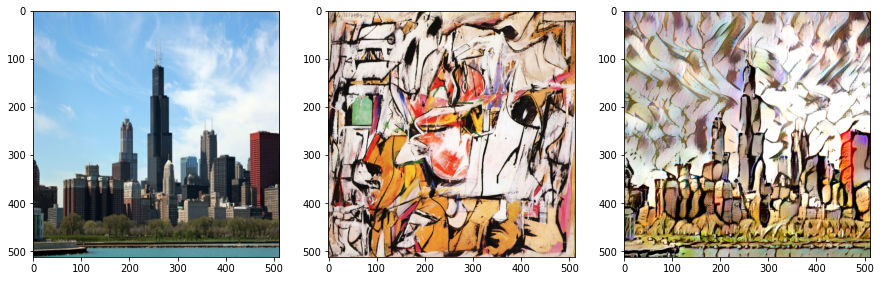

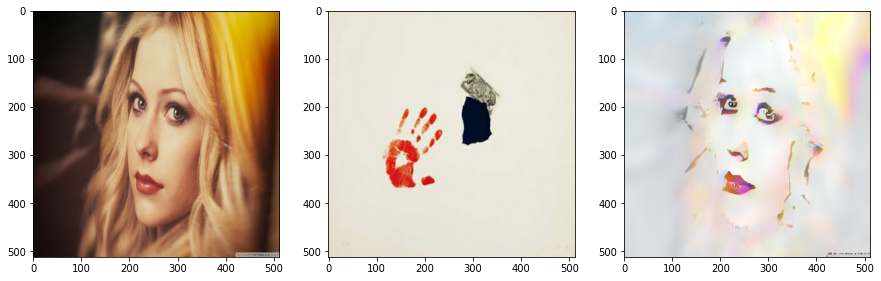

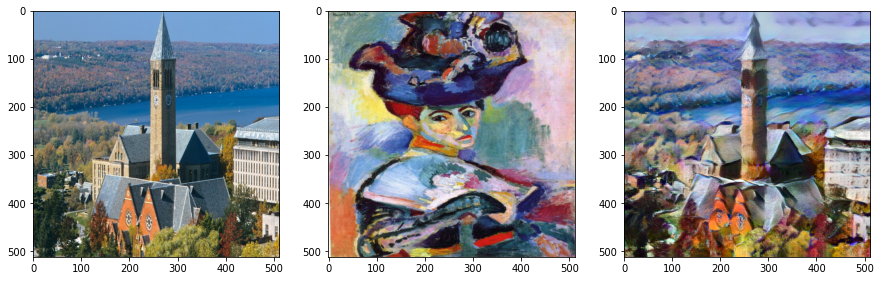

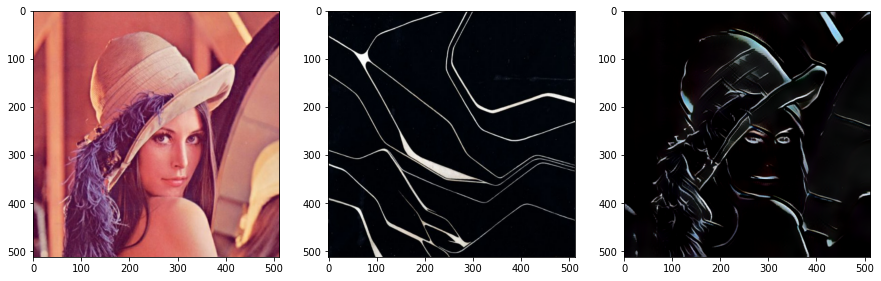

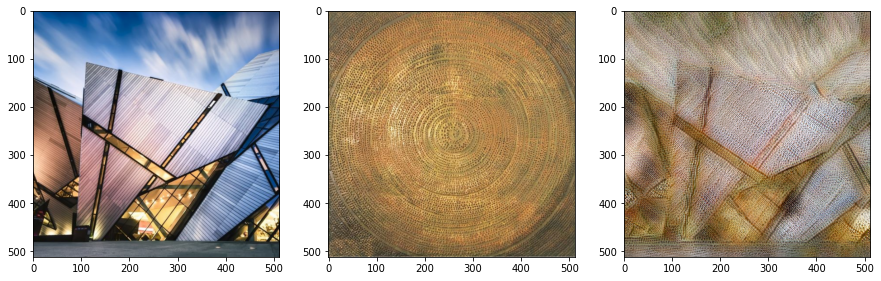

In [120]:
image_files = [ 
                        ['chicago.jpg', 'asheville.jpg'],
                        ['avril.jpg', 'impronte_d_artista.jpg'],
                        ['cornell.jpg', 'woman_with_hat_matisse.jpg'],
                        ['lenna.jpg', 'en_campo_gris.jpg'],
                        ['modern.jpg', 'goeritz.jpg'],
              ]

for content, style in image_files:
    alpha = 1
    stylized, content_image, style_image = styleimage(content, style, alpha, resize=[512,512])
    fig = plt.figure(figsize=(15,20))
    fig.add_subplot(1,3,1)
    plt.imshow(help_display(content_image))
    fig.add_subplot(1,3,2)
    plt.imshow(help_display(style_image))
    fig.add_subplot(1,3,3)
    plt.imshow(help_display(stylized))
    plt.show()